### Title: 
#### Predict Costa Rican Household Poverty Level

### Group Members:
- Cheah Jun Yitt (WQD180107)
- Choong En Jun (WQD180113)
- Choo Jian Wei (WQD180124)
- Tan Yin Yen (WQD180108)

### Overview:
Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.   

The Inter-American Development Bank (IDB) works to improve lives in Latin America and the Caribbean by providing financial and technical support for countries working to reduce poverty and inequality. Household poverty is an important key to IDB’s strategies. 

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

<https://www.kaggle.com/c/costa-rican-household-poverty-prediction>


### Data:

<div style="float:left;">
    <table>
    <tr><td>Title of Dataset</td><td>Costa Rican Household characteristics Dataset</td></tr>
    <tr><td>Year</td><td>2018</td></tr>
    <tr><td>Number of Observations</td><td>9557 observations on Train Dataset<br>23856 observations on Test Dataset</td></tr>
    <tr><td>Number of Variables</td><td>142 columns</td></tr>
    <tr><td>Source</td><td>Uploaded for Kaggle Community Competition by Inter-American Development Bank (IDB)<br>
         <a href="https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data">https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data</a></td></tr>
    <tr><td>Purpose of Dataset</td><td>To challenge existing Proxy Means Test (PMT) algorithm on household poverty prediction</td></tr>
    </table>
</div>






### Table of Content
- Package Installation 
- Reading the Data
- Data Cleaning and Data Preprocessing
    - Dealing with Outliers
    - Dealing with Missing Data
- Visualization
- Modelling
- Model Evaluation
- Conclusion

# Package Installation
### Installation of lightgbm package

In [ ]:
# !pip install lightgbm

### Load python packages

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 150

#for machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import lightgbm as lgb

import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight



# Reading the Data

In [ ]:
train = pd.read_csv('../data/train.csv')
train.info()
train.head()

In [ ]:
test = pd.read_csv('../data/test.csv')
test.info()
test.head()

# Data Cleaning and Data Pre-processing
There are multiple discrepancies in the dataset. Also, we refer to the Kaggle discussion for additional insights regarding the data. 
<br>Following can be said about the raw dataset:
<ol>
  <li>Each line represents to an individual in the household</li>
    <li>The target (poverty level) is segregated to 4 levels (1: extreme poverty, 2: moderate poverty, 3: vulnerable households, 4: non-vulnerable households)</li>
    <li>There are individuals without household</li>
    <li>There are individuals within the same household that does not share the same target poverty level</li>
    <li>Prediction is scored based on head of household only</li>
</ol>

<br>
Without futher due, we perform out own cleaning and preparation of the dataset



In [ ]:
train.describe()
test.describe()


## Dealing with Outliers
**If we look carefully, There is an outlier for attribute rez_esc in test data.**

In [ ]:
print(test.loc[:,"rez_esc"].describe())
test.loc[test.loc[:,"rez_esc"]==99,"rez_esc"]

We can see that there is only one outlier =99, the rest of the test data is okay.  
According to answer from kaggle competition host, the value can be safely changed to 5.  
<https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403>

In [ ]:
test.loc[test.loc[:,"rez_esc"]==99,"rez_esc"]=5
test.loc[:,"rez_esc"].describe()

## Dealing with Missing Data
**Now we will deal with missing values in both test and train dataset.**  
- We will first check for missing values in the columns

In [ ]:
train_na= pd.DataFrame((train.isnull().sum().values),index=train.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    train_na.loc[train_na.loc[:,'isNA']> 0,]
else:
    print('no NA in train set')

test_na= pd.DataFrame((test.isnull().sum().values),index=test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    test_na.loc[test_na.loc[:,'isNA']> 0,]
else:
    print('no NA in test set')

**We can see the missing values are largely from:**

- ***rez_esc: years behind in school:***

- ***v18q1: number of tablets household owns***

- ***v2a1: monthly rent payment***

- ***meaneduc: average years of education for adults***

- ***SQBmeaned is the square of meaneduc***


For the variable ***rez_esc (years behind in school)***,  
data is only available if the age of individual is between 7 to 17 years old.  
We will set 0 to all other null values.

In [ ]:
rez_esc_age=train.loc[train['rez_esc'].isnull()==False, 'age']

plt.hist(x=rez_esc_age,)
plt.xticks(np.arange(min(rez_esc_age), max(rez_esc_age)+1, 1.0),rotation = 60),
plt.ylabel('frequence of rez_esc')
plt.xlabel('Age')
plt.title('Non-null rez_esc Frequency according to age')
plt.show()

***v2a1: monthly rent payment***
    
-    this depends on tipovivi2 and tipovivi3, v2a1 is NA if tipovivi2 or tipovivi3 is 0
    tipovivi2 (a true false statement if an individual owns the house and is paying installment). 
    tipovivi3 (a true false statement if an individual is renting the house). 
    We will assume 0 for NA in v2a1

In [ ]:
tipos=[x for x in train if x.startswith('tipo')]
rentNA_status=train.loc[train['v2a1'].isnull(), tipos].sum()
plt.bar(tipos,rentNA_status,align='center')
plt.xticks([0,1,2,3,4],['Owns and Paid off','Owns and Paying', 'Renting','Precarious','Other'],rotation = 60),
plt.ylabel('Frequency')
plt.title("Missing Rental 'v2a1' according to Home Ownership Status")
plt.show()

***v18q1: number of tablets household owns***

  -  This depends on v18q (a true false statement if an individual own a tablet). v18q1 is NA if v18q is 0
    We will assume 0 for NA in v18q1

In [ ]:
Tablet_status=train.loc[train['v18q1'].isnull(), 'v18q']
plt.hist(x=Tablet_status)
plt.xticks([0,1,2],['Do not Own a Table','Owns a Tablet'],rotation=60),
plt.ylabel('Frequency missing value on v18q1')
plt.xlabel('Individual Tablet Ownership (v18q)')
plt.title('Missing value on household tablet ownership vs individual tablet ownership')
plt.show()

***meaneduc: average years of education for adults***
  -  We will replace this with mode
    
***SQBmeaned is the square of meaneduc***
  - replace with square of replaced meaneduc

In [ ]:
train["meaneduc"].isna().any()

In [ ]:
try: 
    plt.figure(figsize=(10,5))
    plt.hist(x=train['meaneduc'],bins=int(train['meaneduc'].max()))
    plt.xticks(np.arange(min(train['meaneduc']), max(train['meaneduc'])),rotation=60),
    plt.ylabel('Frequency')
    plt.xlabel('average years of education for adults (18+)')
    plt.title('Histogram for meaneduc')
    plt.show()
    
except:
    print("meaneduc contains NA.")


# Impute Missing Values
1. Impute ***meaneduc*** with mode (mode = 6)
2. Impute ***SQBmeaned*** with squared of mode of ***meaneduc*** (mode = 36)
3. Impute ***rez_esc***, ***v18q1*** and ***v2a1*** with 0 

In [ ]:
train.loc[:,"meaneduc"].mode()
#train: mode for meaneduc is 6 replace NA with 6, replace SQBmeaned NA to 36
train.loc[train.loc[:,"meaneduc"].isnull()==True,"meaneduc"] = 6
train.loc[train.loc[:,"SQBmeaned"].isnull()==True,"SQBmeaned"] = 36

test.loc[:,"meaneduc"].mode()
#test: mode for meaneduc is 6 replace NA with 6, replace SQBmeaned NA to 36
test.loc[test.loc[:,"meaneduc"].isnull()==True,"meaneduc"] = 6
test.loc[test.loc[:,"SQBmeaned"].isnull()==True,"SQBmeaned"] = 36


#Replace all NA values for remaining 3 attributes with 0no
train.loc[train.loc[:,"rez_esc"].isnull()==True,"rez_esc"] = 0
train.loc[train.loc[:,"v18q1"].isnull()==True,"v18q1"] = 0
train.loc[train.loc[:,"v2a1"].isnull()==True,"v2a1"] = 0

test.loc[test.loc[:,"rez_esc"].isnull()==True,"rez_esc"] = 0
test.loc[test.loc[:,"v18q1"].isnull()==True,"v18q1"] = 0
test.loc[test.loc[:,"v2a1"].isnull()==True,"v2a1"] = 0


## Check for Missing Values

In [ ]:
#Check for missing values again:
train_na= pd.DataFrame((train.isnull().sum().values),index=train.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    train_na.loc[train_na.loc[:,'isNA']> 0,]

else:
    print('No NA in train set')

test_na= pd.DataFrame((test.isnull().sum().values),index=test.columns, columns=['isNA']).sort_values(by=['isNA'],ascending=False)
if train_na.loc[train_na.loc[:,'isNA']>0,:].shape[0]>1 :
    test_na.loc[test_na.loc[:,'isNA']> 0,]
else:
    print('No NA in test set')

### Investigate if all individuals in the household have the same poverty target

In [ ]:
target_Discrepancy=(train.groupby('idhogar')['Target'].nunique()>1)
num_unique_households = train["idhogar"].unique().shape[0]
print('There are',target_Discrepancy.sum(),'households with contradicting targets, out of', num_unique_households, 'households in the train dataset.')

**Let's see the data for 85 households that have discrepancy in target poverty level**

In [ ]:
Discrepancy_Index=(train.groupby('idhogar')['Target'].transform('nunique')>1)
HHID_Discrepancy=train.loc[Discrepancy_Index,'idhogar'].unique()
#household with contradicting target
train.loc[train['idhogar'].isin(HHID_Discrepancy),['idhogar','parentesco1','Target']].head()

**Judging from the data, the household head target might not be necessary true. Although prediction scoring is based on household head target, we should be able to safely replace the household target using the mode target of the household.**


In [ ]:

for HH in HHID_Discrepancy:
    Targets= (train.loc[train['idhogar']==HH,'Target'])

    if Targets.mode().shape[0] >1:
        for i in Targets.index:
            if train.loc[i,'parentesco1']==1:
                HeadTarget= train.loc[i,"Target"]    
        for i in Targets.index:
            train.loc[i,'Target']=HeadTarget
    elif Targets.mode().shape[0]==1:
        for i in Targets.index:
            TrueTarget=int(Targets.mode())
            train.loc[i,'Target']=TrueTarget
        


**Check for household targets discrepancy again for confirmation**

In [ ]:
target_Discrepancy=(train.groupby('idhogar')['Target'].nunique()>1)

print('There are ',target_Discrepancy.sum(),'households with contradicting targets, out of 2988 households in the train dataset')

train.head()
train.shape

**Remove (SQBescolari, SQBage, SQBHogar_ttal,SQBedjefe, SQBhogar_nin,SQBovercrowding, SQBdependency, SQBMeaned, agesq)**  
There are 9 columns where the attributes are the squared of other attributes. We do not need those in our model as the model are smart enough to detect non-linear relationship.



In [ ]:
train=train.drop(columns=train.columns[133:142],axis=1)
test=test.drop(columns=test.columns[133:142],axis=1)

In [ ]:
print(train.shape)
print(test.shape)

# Visualization

## Household Level Features Visualization

**We Can Segregate the attributes into different categories**<br>
1st is by Household level or Individual level<br>
2nd is by Numerical or Categorical True/False<br>

So we will have 4 types of data<br>
-Household Numerical<br>
-Individual Numerical<br>
-Household Categorical<br>
-Individual Categorical<br>

For simple EDA, we will only look at training dataset, and plot a box plot on the numerical household variables.

In [ ]:
#These are Household Numerical columns. Attribute "Dependency" is not included since it has some yes and no elements
catColumnsHH= ["v2a1","rooms","v18q1","qmobilephone","r4h3","r4m3","r4t3","tamhog","hhsize","hogar_nin","hogar_adul",
               "hogar_mayor","hogar_total","meaneduc","bedrooms","overcrowding"]

In [ ]:
fig, ax =plt.subplots(6,3, figsize=(18,15))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i in range(0,len(catColumnsHH)):
    if (i>0) & (i %3==0):
        x=x+1
        y=0
    sns.boxplot(x="Target",y=catColumnsHH[i], data=train, ax=ax[x,y])
    ax[x,y].title.set_text(catColumnsHH[i])
    y=y+1


**At one glance the box plot is useful compare the 4 targets' summary statistic of each variables plotted.**  
So far, the box plot make sense as we look at the slight difference in the variable mean between targets.  
1) number of mobile phone per househould - mean is lower in poverty level 1 and 2 indicating less affordability  
2) number of children "hogar_nin" - mean is lower in poverty level 3 & 4 indicating less commitment  
3) number of adults "hogar_adul" - mean is lower in poverty level 1 meaning less earning power  
4) mean education "mean educ: - mean has a upwarding bias from poverty level 1 to 4  
5) overcrowding - mean has a decreasing bias from poverty level 1 to 4  


## Visualize Living Conditions by Poverty Level

**For this section, we use data points for head of household only. We want to avoid having frequencies that were inflated by the number of individuals in a house.**

In [ ]:
cond_data = train.query("parentesco1==1").copy()
cond_data.shape


### Visualize Various Household Conditions related Attributes by Poverty Level

In [ ]:
wall = ["paredblolad","paredzocalo","paredpreb","pareddes","paredmad","paredzinc","paredfibras","paredother"]
floor = ["pisomoscer","pisocemento","pisoother","pisonatur","pisonotiene","pisomadera"]
roof = ['techozinc','techoentrepiso','techocane','techootro', 'cielorazo']
water = ["abastaguadentro","abastaguafuera","abastaguano"]
electric = ["public","planpri","noelec","coopele"]
toilet = ['sanitario1','sanitario2','sanitario3','sanitario5','sanitario6']
energy = ['energcocinar1','energcocinar2','energcocinar3','energcocinar4']
rubbish = ['elimbasu1','elimbasu2','elimbasu3','elimbasu4','elimbasu5','elimbasu6']
wall_cond = ['epared1','epared2','epared3']
roof_cond = ['etecho1','etecho2','etecho3']
floor_cond = ['eviv1','eviv2','eviv3']

col_types = [wall, floor, roof, water, electric, toilet, energy, rubbish, wall_cond, roof_cond, floor_cond]
titles = ['wall', 'floor', 'roof', 'water', 'electric', 'toilet', 'energy', 'rubbish', 'wall condition', 'roof condition', 'floor condition']

fig, ax =plt.subplots(len(col_types)//3 + 1, 3, figsize=(30,10))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i, cols in enumerate(col_types):
    if (i>0) & (i % 3==0):
        x=x+1
        y=0
    title = titles[i]
    plot_df = pd.melt(cond_data, id_vars=['Target'], value_vars=cols).groupby(["Target","variable"]).apply(lambda x: np.mean(x))
    plot_df["variable"] = plot_df.index.get_level_values(1)
    plot_df = plot_df.rename(columns = dict(value="Percentage Frequency", variable = "Attribute"))
    sns.barplot(x="Attribute", y = "Percentage Frequency", hue="Target", data=plot_df, ax=ax[x,y])
    ax[x,y].title.set_text(title)
    y=y+1



Based on the plot above, Household with Target=4 tend to have a wall made of block or brick.<br>
Also, Households with Target=4 tend to have floor made of mosaic, ceramic, terrazo. (pisomoscer = 1)<bR>
    
If we look at the living condition scoring variables for wall (epared1), roof (etecho1), and floor (eviv1), we can see that the households inclined towards extreme poverty level are highly concentrated towards bad living conditions for the three variables mentioned.



## Visualize Features by Geographical Locations

**As we have look at the features based on targets, we shall also view at it based on geographical locations.**

In [ ]:
region = ["lugar1","lugar2","lugar3","lugar4","lugar5","lugar6"]
area= ["area1","area2"]

col_types = [region, area]
titles = ['region', 'area']

fig, ax =plt.subplots(1,2, figsize=(15,5))
plt.subplots_adjust(top=1.0)
x=0
y=0
for i, cols in enumerate(col_types):
    if (i>0) & (i % 3==0):
        x=x+1
        y=0
    title = titles[i]
    plot_df = pd.melt(cond_data, id_vars=['Target'], value_vars=cols).groupby(["Target","variable"]).apply(lambda x: np.mean(x))
    plot_df["variable"] = plot_df.index.get_level_values(1)
    plot_df = plot_df.rename(columns = dict(value="Percentage Frequency", variable = "Attribute"))
    sns.barplot(x="Attribute", y = "Percentage Frequency", hue="Target", data=plot_df, ax=ax[y])
    ax[y].title.set_text(title)
    y=y+1



We can see that that area 1, urban area has a higher convenctration of non-vulnerable poverty level group.
As for the regions, lugar 1 which is the central and has a healthy increasing population trend towards poverty non-vulnerabe group. 
Whereas in other region, lugar 2 to 6 population trend have concentration gradually decreasing from poverty extreme toward poverty non-vulnerable.

In [ ]:
geoTrain= train.loc[train['parentesco1'] == 1, :]
geoTrain['lugar'] = np.argmax(np.array(cond_data[["lugar1","lugar2","lugar3","lugar4","lugar5","lugar6"]]),
                           axis = 1)
geoTrain['lugar']=geoTrain['lugar'].replace({5:6,4:5,3:4,2:3,1:2,0:1})


In [ ]:
wall = ["paredblolad","paredzocalo","paredpreb","pareddes","paredmad","paredzinc","paredfibras","paredother"]
floor = ["pisomoscer","pisocemento","pisoother","pisonatur","pisonotiene","pisomadera"]
roof = ['techozinc','techoentrepiso','techocane','techootro', 'cielorazo']
water = ["abastaguadentro","abastaguafuera","abastaguano"]
electric = ["public","planpri","noelec","coopele"]
toilet = ['sanitario1','sanitario2','sanitario3','sanitario5','sanitario6']
energy = ['energcocinar1','energcocinar2','energcocinar3','energcocinar4']
rubbish = ['elimbasu1','elimbasu2','elimbasu3','elimbasu4','elimbasu5','elimbasu6']
wall_cond = ['epared1','epared2','epared3']
roof_cond = ['etecho1','etecho2','etecho3']
floor_cond = ['eviv1','eviv2','eviv3']

col_types = [wall, floor, roof, water, electric, toilet, energy, rubbish, wall_cond, roof_cond, floor_cond]
titles = ['wall', 'floor', 'roof', 'water', 'electric', 'toilet', 'energy', 'rubbish', 'wall condition', 'roof condition', 'floor condition']

fig, ax =plt.subplots(len(col_types)//3 + 1, 3, figsize=(30,10))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i, cols in enumerate(col_types):
    if (i>0) & (i % 3==0):
        x=x+1
        y=0
    title = titles[i]
    plot_df = pd.melt(geoTrain, id_vars=['lugar'], value_vars=cols).groupby(["lugar","variable"]).apply(lambda x: np.mean(x))
    plot_df["variable"] = plot_df.index.get_level_values(1)
    plot_df = plot_df.rename(columns = dict(value="Percentage Frequency", variable = "Attribute"))
    sns.barplot(x="Attribute", y = "Percentage Frequency", hue="lugar", data=plot_df, ax=ax[x,y])
    ax[x,y].title.set_text(title)
    y=y+1



From the above plots, we can see that lugar 2 to 6 consistently tops the chart for bad condition of the wall (epared1), roof (etecho1), and floor (eviv1). Perhaps visually, we can deduce that Pacífico Central (lugar 3) and Brunca (lugar 4) have it worst among all other regions.   

**Now let's look at numerical features based on geographical location to see if we can find anything interesting.**

In [ ]:
fig, ax =plt.subplots(6,3, figsize=(18,15))
plt.subplots_adjust(top=2.0)
x=0
y=0
for i in range(0,len(catColumnsHH)):
    if (i>0) & (i %3==0):
        x=x+1
        y=0
    sns.boxplot(x="lugar",y=catColumnsHH[i], data=geoTrain, ax=ax[x,y])
    ax[x,y].title.set_text(catColumnsHH[i])
    y=y+1


In general, the boxplot tells us what we already suspected. lugar 3 shows the highest mean for overcrowding indicating worst living conditions in this geographical region. 

# Feature Engineering

**Since prediction is scored only for the household head. We need to make new features that is household level and not individual.**  
**Besides, we have created a new scoring system for education level (*instlevel*), by giving higher score to individual that has completed tertiary education.**

In [ ]:
#Setting new features for household specific in train data

#Number of Adults not including seniors >65
train['Adults']=train['hogar_adul']-train['hogar_mayor']
#Number of children < 19yo and seniors>65
train['Dependents']=train['hogar_nin']+train['hogar_mayor']
#Number of teenager from 12 to 19
train['Teenagers']=train['hogar_nin']-train['r4t1']
#Dependency is number of dependents per adults. This replaces the original dependency data from dataset.
train['dependency']=train['Dependents']/train['Adults']
#Percentage of Adults in household
train['P_Adults']=train['Adults']/train['hogar_total']
#Percentage of Male Adults in household
train['P_Adults_Male']=train['r4h3']/train['hogar_total']
#Percentage Female Adults in household
train['P_Adults_Female']=train['r4m3']/train['hogar_total']
#Percentage Children <19yo in household
train['P_Children']=train['hogar_nin']/train['hogar_total']
#Percentage of Seniors in household
train['P_Seniors']=train['hogar_mayor']/train['hogar_total']
#Percentage of Teenagers in household
train['P_Teenagers']=train['Teenagers']/train['hogar_total']
#Rent per person in household
train['RentHH']=train['v2a1']/train['hogar_total']
#Rent per Adult in household
train['RentAdults'] = train['v2a1']/train['Adults']
train['RentAdults'] = train['RentAdults'].fillna(train['v2a1']) # Replace NA value with the Rent value itself (Assume Adults = 0 as Adults = 1, there has to be 1 adult to pay the Rent amount.)

#Tablet per person in household
train['Tablet_PP']=train['v18q1']/train['hogar_total']
#Mobile Phone per person in household
train['Phone_PP']=train['qmobilephone']/train['hogar_total']
#Bedroom per person in household
train['Bedroom_PP']=train['bedrooms']/train['hogar_total']
#Appliance scoring. Higher the better
train['Appliances']=train['refrig']+train['computer']+train['television']
#Number of Appliances per person
train['Appliances_PP']=train['Appliances']/test['hogar_total']

#Household size Difference
train['HHS_Diff']=train['tamviv']-train['hhsize']

#Number of Adults per room
train["AdultsPerRoom"] = train['Adults']/train['rooms']
#Number of Dependents per room
train["DependentsPerRoom"] = train['Dependents']/train['rooms']
#Number of Teenagers per room
train["TeenagersPerRoom"] = train['Teenagers']/train['rooms']

#Number of Males per room
train["MalesPerRoom"] = train['r4h3']/train['rooms']
#Number of Females per room
train["FemalesPerRoom"] = train['r4m3']/train['rooms']

#Percentage of rooms that are bedrooms
train["BedroomPerRoom"] =  train['bedrooms']/train['rooms']
train["RentPerRoom"] =  train['v2a1']/train['rooms']

#Years of Schooling over Age
train["Schooling_Age"]  = train["escolari"]/train["age"]

#Years behind schooling vs Years of schooling proportion
train['SchoolingProp'] = train['rez_esc']/train['escolari']


#New Scoring For Education Level
train["EduLevel"] = 0 
train.loc[train["instlevel9"] == 1,"EduLevel"] = 6
train.loc[train["instlevel8"] == 1,"EduLevel"] = 5 #higher scoring for completing tertiary education
train.loc[train["instlevel7"] == 1,"EduLevel"] = 3
train.loc[train["instlevel5"] == 1,"EduLevel"] = 2
train.loc[(train[["instlevel4","instlevel3","instlevel6"]].sum(axis = 1) > 0),"EduLevel"] = 1

train.head()

#We replicate the same for test data since we need the same features for prediction

test['Adults']=test['hogar_adul']-test['hogar_mayor']
test['Dependents']=test['hogar_nin']+test['hogar_mayor']
test['Teenagers']=test['hogar_nin']-test['r4t1']
test['dependency']=test['Dependents']/test['Adults']
test['P_Adults']=test['Adults']/test['hogar_total']
test['P_Adults_Male']=test['r4h3']/test['hogar_total']
test['P_Adults_Female']=test['r4m3']/test['hogar_total']
test['P_Children']=test['hogar_nin']/test['hogar_total']
test['P_Seniors']=test['hogar_mayor']/test['hogar_total']
test['P_Teenagers']=test['Teenagers']/test['hogar_total']
test['RentHH']=test['v2a1']/test['hogar_total']

test['RentAdults']=test['v2a1']/test['Adults']
test['RentAdults'] = test['RentAdults'].fillna(test['v2a1']) # Replace NA value with the Rent value itself (Assume Adults = 0 as Adults = 1, there has to be 1 adult to pay the Rent amount.)

test['Tablet_PP']=test['v18q1']/test['hogar_total']
test['Phone_PP']=test['qmobilephone']/test['hogar_total']
test['Bedroom_PP']=test['bedrooms']/test['hogar_total']
test['Appliances']=test['refrig']+test['computer']+test['television']
test['Appliances_PP']=test['Appliances']/test['hogar_total']
test['HHS_Diff']=test['tamviv']-test['hhsize']

test["AdultsPerRoom"] = test['Adults']/test['rooms']
test["DependentsPerRoom"] = test['Dependents']/test['rooms']
test["TeenagersPerRoom"] = test['Teenagers']/test['rooms']

test["MalesPerRoom"] = test['r4h3']/test['rooms']
test["FemalesPerRoom"] = test['r4m3']/test['rooms']

test["BedroomPerRoom"] =  test['bedrooms']/test['rooms']
test["RentPerRoom"] =  test['v2a1']/test['rooms']

test["Schooling_Age"]  = test["escolari"]/test["age"]
test['SchoolingProp'] = test['rez_esc']/test['escolari']

#New Scoring For Education Level
test["EduLevel"] = 0 
test.loc[test["instlevel9"] == 1,"EduLevel"] = 6
test.loc[test["instlevel8"] == 1,"EduLevel"] = 5 #higher scoring for completing tertiary education
test.loc[test["instlevel7"] == 1,"EduLevel"] = 3
test.loc[test["instlevel5"] == 1,"EduLevel"] = 2
test.loc[(test[["instlevel4","instlevel3","instlevel6"]].sum(axis = 1) > 0),"EduLevel"] = 1

test.head()

## Aggregate Features at the Household Level
**Now we want to aggregate existing features to be representable at the household level.**   
1. We aggregate variables in 'List_Mean' by taking the mean across all individuals in their respective household.
2. We aggregate variables in 'List_Summary' by taking the mean, standard deviation, min, max, and sum across all individuals in their respective household.
3. We added 'age_range' and 'escolari_range', which calculates the range of age and years of schooling across all individuals in their respective household.


In [ ]:
List_Mean = ['rez_esc', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',
             'estadocivil6', 'estadocivil7', 'parentesco2','parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',
             'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12','instlevel1', 'instlevel2', 'instlevel3',
             'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9','overcrowding']

List_Summary = ['age', 'escolari','dis','EduLevel', 'Schooling_Age']

trainGP = pd.DataFrame()
testGP = pd.DataFrame()

for item in List_Mean:
    group_train_mean = train[item].groupby(train['idhogar']).mean()
    group_test_mean = test[item].groupby(test['idhogar']).mean()
    new_col = item + '_mean'
    trainGP[new_col] = group_train_mean
    testGP[new_col] = group_test_mean

for item in List_Summary:
    for function in ['mean','std','min','max','sum']:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        new_col = item + '_' + function
        trainGP[new_col] = group_train
        testGP[new_col] = group_test
        
#adding one final feature
trainGP['age_extreme']=trainGP['age_max']-trainGP['age_min']
testGP['age_extreme']=testGP['age_max']-testGP['age_min']
trainGP['escolari_extreme']=trainGP['escolari_max']-trainGP['escolari_min']
testGP['escolari_extreme']=testGP['escolari_max']-testGP['escolari_min']

# Impute 0 to std columns (taking standard deviation on 1 value will yield NA)
trainGP["age_std"] = trainGP["age_std"].fillna(0)
trainGP["escolari_std"] = trainGP["escolari_std"].fillna(0)
trainGP["dis_std"] = trainGP["dis_std"].fillna(0)
trainGP["EduLevel_std"] = trainGP["EduLevel_std"].fillna(0)
trainGP["Schooling_Age_std"] = trainGP["Schooling_Age_std"].fillna(0)

testGP["age_std"] = testGP["age_std"].fillna(0)
testGP["escolari_std"] = testGP["escolari_std"].fillna(0)
testGP["dis_std"] = testGP["dis_std"].fillna(0)
testGP["EduLevel_std"] = testGP["EduLevel_std"].fillna(0)
testGP["Schooling_Age_std"] = testGP["Schooling_Age_std"].fillna(0)
    
trainGP.head()
testGP.head()

# Features about Living Conditions

In [ ]:
#Sufficiency Features (self-defined conditions for a sufficient living conditions)

# =1 if predominant material on the outside wall is block or brick
# =1 if predominant material on the floor is mosaic, ceramic, terrazo
# =1 if the house has ceiling
# =1 if water provision inside the dwelling
# =1 electricity from CNFL,ICE, ESPH/JASEC
# =1 toilet connected to sewer or cesspool
# =1 main source of energy used for cooking electricity
# =1 if rubbish disposal mainly by tanker truck
# =1 if walls are good
# =1 if roof are good
# =1 if floor are good

train["GoodCondition"] = train["paredblolad"] + \
                                train["pisomoscer"] + \
                                train["cielorazo"] + \
                                train["abastaguadentro"] + \
                                train["public"] + \
                                train["sanitario2"] + \
                                train["energcocinar2"] + \
                                train["elimbasu1"] + \
                                train["epared3"] + \
                                train["etecho3"] + \
                                train["eviv3"] 
train["GoodCondition"] = train["GoodCondition"]/11   # Take the mean to get a GoodCondition score between 0 and 1     

# =1 if predominant material on the outside wall is socket (wood, zinc or abesto) OR prefabricated or cement
# =1 if predominant material on the roof is metal foil or zink
# =1 if water provision outside the dwelling
# =1 electricity from cooperative
# =1 toilet connected to  septic tank
# =1 main source of energy used for cooking gas
#  =1 if rubbish disposal mainly by botan hollow or buried
# =1 if walls are regular
#  =1 if roof are regular
#  =1 if floor are regular
train["AverageCondition"] = (train["paredzocalo"] + train["paredpreb"])/2 + \
                                train["techozinc"] + \
                                train["abastaguafuera"] + \
                                train["coopele"] + \
                                train["sanitario3"] + \
                                train["energcocinar3"] + \
                                train["elimbasu2"] + \
                                train["epared2"] + \
                                train["etecho2"] + \
                                train["eviv2"] 

train["AverageCondition"] = train["AverageCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     


# =1 if predominant material on the outside wall is waste material OR wood OR zinc
# =1 if predominant material on the floor is cement OR wood OR no floor
# =1 if no water provision
# =1 no electricity in the dwelling
# =1 no toilet in the dwelling OR toilet connected to black hole or letrine
# =1 no main source of energy used for cooking (no kitchen) OR  =1 main source of energy used for cooking wood charcoal
# =1 if rubbish disposal mainly by burning
# =1 if walls are bad
# =1 if roof are bad
# =1 if floor are bad
train["BadCondition"] = (train["pareddes"] + train["paredmad"] + train["paredzinc"])/3 + \
                        (train["pisocemento"] + train["pisonotiene"] + train["pisomadera"])/3 + \
                        train["abastaguano"] + \
                        train["noelec"] + \
                        (train["sanitario1"] + train["sanitario5"])/2 + \
                        (train["energcocinar1"] + train["energcocinar4"])/2 + \
                        train["elimbasu3"] + \
                        train["epared1"] + \
                        train["etecho1"] + \
                        train["eviv1"]

train["BadCondition"] = train["BadCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     

# add the 3 features to the test set
test["GoodCondition"] = test["paredblolad"] + \
                                test["pisomoscer"] + \
                                test["cielorazo"] + \
                                test["abastaguadentro"] + \
                                test["public"] + \
                                test["sanitario2"] + \
                                test["energcocinar2"] + \
                                test["elimbasu1"] + \
                                test["epared3"] + \
                                test["etecho3"] + \
                                test["eviv3"] 
test["GoodCondition"] = test["GoodCondition"]/11   # Take the mean to get a GoodCondition score between 0 and 1     

test["AverageCondition"] = (test["paredzocalo"] + test["paredpreb"])/2 + \
                                test["techozinc"] + \
                                test["abastaguafuera"] + \
                                test["coopele"] + \
                                test["sanitario3"] + \
                                test["energcocinar3"] + \
                                test["elimbasu2"] + \
                                test["epared2"] + \
                                test["etecho2"] + \
                                test["eviv2"] 

test["AverageCondition"] = test["AverageCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     

test["BadCondition"] = (test["pareddes"] + test["paredmad"] + test["paredzinc"])/3 + \
                        (test["pisocemento"] + test["pisonotiene"] + test["pisomadera"])/3 + \
                        test["abastaguano"] + \
                        test["noelec"] + \
                        (test["sanitario1"] +test["sanitario5"])/2 + \
                        (test["energcocinar1"] + test["energcocinar4"])/2 + \
                        test["elimbasu3"] + \
                        test["epared1"] + \
                        test["etecho1"] + \
                        test["eviv1"]

test["BadCondition"] = test["BadCondition"]/10   # Take the mean to get a GoodCondition score between 0 and 1     

**Now we merge the aggregated features, all existing features and added features for the head of household.**



In [ ]:
trainGP = trainGP.reset_index()
testGP = testGP.reset_index()

trainML = pd.merge(train, trainGP, on='idhogar')
testML = pd.merge(test, testGP, on='idhogar')

trainML = trainML.query("parentesco1==1") #use only head of household for prediction

#fill all na as 0
# trainML.fillna(value=0, inplace=True)
# testML.fillna(value=0, inplace=True)

 #.query("idhogar==1").head()
# testML.head()

train.shape, test.shape, trainGP.shape, testGP.shape,  trainML.shape, testML.shape 

## Check for Missing Values before Modelling


In [ ]:
trainML.isna().any().any(),testML.isna().any().any()

### Record the ID for submission

In [ ]:
submission = testML.copy()[['Id']]

### Data Reduction
**Remove features that are irrelevant such as 'idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe', and 'edjefa'.**

In [ ]:
trainML.drop(columns=['idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe','edjefa'],inplace=True)
testML.drop(columns=['idhogar','Id','tamhog','r4t3','hhsize','hogar_adul','edjefe','edjefa'],inplace=True)


### Correlation of features variables with the Target

In [ ]:
correlation=trainML.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positively correlated feature: \n{correlation.head(20)}')
print('*'*50)
print(f'The most 20 negatively correlated feature: \n{correlation.tail(20)}')

**Notice that there is a few attributes with NaN. We will remove them.**


In [ ]:
columns_remove = ['elimbasu5','estadocivil1','parentesco1','parentesco2','parentesco3','parentesco4','parentesco5','parentesco6','parentesco7','parentesco8','parentesco9','parentesco10','parentesco11','parentesco12']
trainML.drop(columns=columns_remove, inplace=True)
testML.drop(columns=columns_remove, inplace=True)

# Modelling
**With the train and test data finally preprocessed. We will make use of the Light GBM model and parameters adjusted from MIsha Lisovyi.**    
*source: <https://www.kaggle.com/mlisovyi/lighgbm-hyperoptimisation-with-f1-macro>*  
**Note that we will not split the training data into train and test set, because the test performance can be assessed by submitting the submission file to Kaggle.**

In [38]:
y = trainML['Target']
X = trainML.drop(columns=['Target'])

Xtest = testML.copy()


In [82]:
from sklearn.metrics import f1_score
def evaluate_macroF1_lgb(truth, predictions): 
    predictions = np.resize(predictions, new_shape=(4,len(truth)))
    pred_labels = predictions.argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    eval_name, val, is_higher_better = "macroF1", f1, True
    return (eval_name, val, is_higher_better) 

#parameter value is copied
# clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.01, objective='multiclass',
#                              random_state=123, silent=True, metric='None', 
#                              n_jobs=4, n_estimators=5000, class_weight='balanced',
#                              colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 15, subsample = 0.96)
clf = lgb.LGBMClassifier(max_depth=10, learning_rate=0.01, objective='multiclass',
                             random_state=123, silent=True, metric='None', 
                             n_jobs=4, n_estimators=2500, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 21, subsample = 0.96)

clf

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.93, importance_type='split', learning_rate=0.01,
        max_depth=10, metric='None', min_child_samples=95,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=2500,
        n_jobs=4, num_leaves=21, objective='multiclass', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.96,
        subsample_for_bin=200000, subsample_freq=0)

## Stratified K-Fold Cross-Validation
**We will perform a Stratified K-Fold Cross Validation to train K = 5 Light GBM models and aggregate the predictions by means of 'voting'.**

In [97]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state = 123)

**Quick check to make sure the train and test dataset have the same columns size**

In [99]:
X.shape, Xtest.shape

((2973, 196), (23856, 196))

## Train the Model

In [ ]:
val_predictions_logloss = []
test_predictions_logloss = []
test_predictions_logloss_proba = []
for train_index, val_index in kf.split(X, y):
    print("=======")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss",
            early_stopping_rounds=400, verbose=200)
    val_predictions_logloss.append(clf.predict(X_val)) 
    test_predictions_logloss.append(clf.predict(Xtest)) # store predictions on test set for Kaggle Submission
    test_predictions_logloss_proba.append(clf.predict_proba(Xtest)) # store predictions probability on test set for Kaggle Submission


# Features Importance
**We visualize the features importance generated from the trained Light GBM model.**
**The top 100 features were plotted.**

Text(0.5, 1.0, 'LightGBM feature importance')

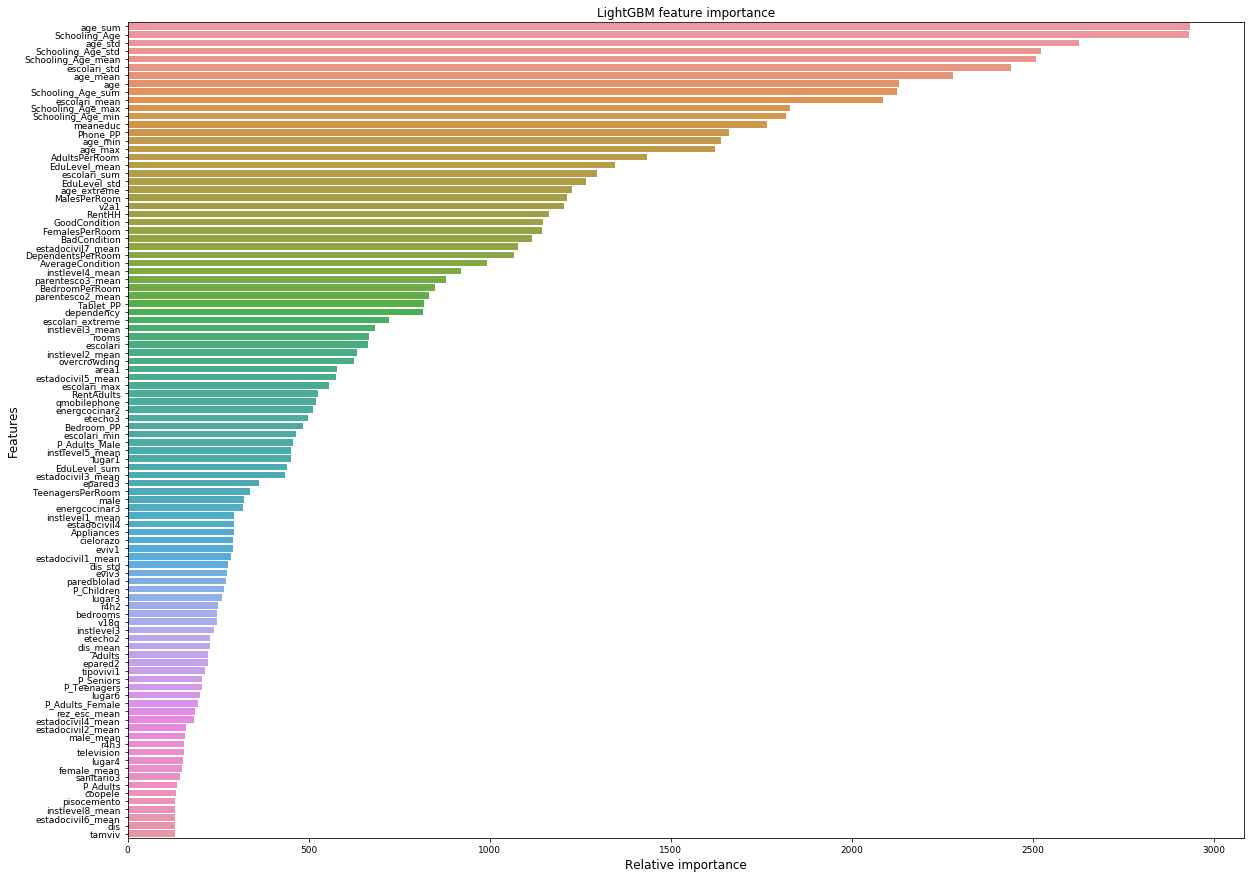

In [87]:
indices = np.argsort(clf.feature_importances_)[::-1]
top_100_indices = indices[:100]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=X.columns[top_100_indices], x = clf.feature_importances_[top_100_indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance")

**From the plot above, we understand that the maximum and average age of individuals in a household, overcrowding, years of schooling, average education level and number of tablets own per person are among the most important features on predicting the poverty level of a household.**

# Feature Selection
**We will attempt to re-train the model by selecting the top 100 features based on the previously trained Light GBM model features importance output. The intuition is to remove variables that have very little influence in predicting the Target (poverty level) and give the model more focus on the important variables.**

In [ ]:
X2 = X.iloc[:,top_100_indices]
Xtest2 = testML.copy().iloc[:,top_100_indices]

# Re-training on top 100 features
test_predictions2 = []
test_predictions_proba2 = []
top100_lgbm_list = []
for train_index, val_index in kf.split(X2, y):
    print("=======")
    X_train, X_val = X2.iloc[train_index], X2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss",
            early_stopping_rounds=400, verbose=200)
    top100_lgbm_list.append(clf)
    test_predictions2.append(clf.predict(Xtest2)) # store predictions on test set for Kaggle Submission
    test_predictions_proba2.append(clf.predict_proba(Xtest2)) 


4    0.561536
3    0.187584
2    0.164571
1    0.086310
Name: Target, dtype: float64

# Submission: Prediction on Test Data

**We take the mean of the predictions made by the 5 models we trained earlier using 5-fold Stratified cross validation.**

In [ ]:
# All Features Model Predictions using Logloss
submission_full_logloss = submission.copy()
voted_test_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_predictions_logloss) # Take the mode
submission_full_logloss['Target'] = np.array(voted_test_predictions).astype(int)
submission_full_logloss.to_csv("submission_full_logloss_06.csv", index=False)
submission_full_logloss['Target'].value_counts()/submission_full_logloss['Target'].value_counts().sum()

**We make another attempt by taking the mode of the predictions made by the 5 models we trained earlier using 5-fold Stratified cross validation.**

In [57]:
# All Features Model Predictions
submission_full = submission.copy()

# Vote on the final target using Mode
test_pred_df = pd.DataFrame(test_predictions)
voted_test_predictions = test_pred_df.T.mode(axis = 1).iloc[:,0].values

submission_full['Target'] = np.array(voted_test_predictions).astype(int)
submission_full['Target'].value_counts()


4    16569
2     3976
3     2181
1     1130
Name: Target, dtype: int64

In [52]:
# All Features Model Predictions using Logloss
submission_full_logloss = submission.copy()
voted_test_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_predictions2) # Take the mode
submission_full_logloss['Target'] = np.array(voted_test_predictions).astype(int)
submission_full_logloss.to_csv("submission_part_logloss_06.csv", index=False)
submission_full_logloss['Target'].value_counts()/submission_full_logloss['Target'].value_counts().sum()

4    16504
2     3922
3     2250
1     1180
Name: Target, dtype: int64

**The DataFrame containing the Predictions on the Test Data is saved to a csv for submission in Kaggle.**  
*Competition Leaderboard: <https://www.kaggle.com/c/costa-rican-household-poverty-prediction/leaderboard>*

In [58]:
submission_full.to_csv('submission_lgb_10.csv',index=False)
submission_mode.to_csv('submission_lgb_11.csv',index=False)



In [ ]:
# Test Result:
submission_mode.head()

### Test Performance

# Conclusion
The highest score in this Kaggle competition is slightly below 0.5, that is hardly good. 

One of the particpants, <a href="https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough">Will Koehrsen</a> has plotted a PCA plot and mentioned:
   <body>
      <img src="https://www.kaggleusercontent.com/kf/5196152/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..-8HLHhWco2POA5ts82e6fA.4CiL2bLptXJ4ZmejyBrX0rO3dqFSs2AGfZA-yQp8G_cD86tY5CdY0FlwRNxdQsURgAeIsnYt2RfmCmzrR8kb-lsEvGTutGy1NN--K6p__ZEDGFV7k0GVqHcXUkYf759g7BElrn4LW4brds9R_uEjDFsU5coC9Wn7_OCJLR3x-apg0P032zXYiANNbUPoU5Dn.CdvKtj0MO30zQd4ylfIMkA/__results___files/__results___332_1.png" alt="Site Logo" width="300" height="300">
   </body>
   <blockquote>It's difficult to see much clustering in these plots, which indicates that separating the poverty levels is hard given the available data. Machine learning models are only as effective as the data we give to them, and sometimes the data does not have enough information.</blockquote>

It is true that based on the exploration on the data that we have performed, most of the attributes (toal 142 columns) are not significant in helping with predicting poverty class. On the original data given, there are many discrepancy in the data and raise some doubts on the quality of the data collected. 

On the bright side, all good things have to start from step one. This competition had combined the bright minds on kaggle and brought about great insights and perspective on what features might be important and what might be not. The highest scoring kernels are consistenly product of a few machine learning methods such as Light GBM and XGboost. While the list of features importance varies accross machine learning models and on how participants preprocess their data, there are a few that frequent the top feature importance list such as:<br>
1) mean education<br>
2) dependency<br>

Roads are not built in a day. With the knowledge sharing available on kaggle kernels, The Inter-American Development Bank (IDB)  organizer can make data driven decision on what data to collect and what not to collect. That will help them to place more emphasis on the more important task and hopefully develop a much better set of data through selective collection. 